In [1]:
%matplotlib inline


# Eddy detection : Med

Script will detect eddies on adt field, and compute u,v with method add_uv(which could use, only if equator is avoid)

Figures will show different step to detect eddies.


In [2]:
from datetime import datetime

from matplotlib import pyplot as plt
from numpy import arange

from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset

In [4]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    ax.set_xlim(-6, 36.5), ax.set_ylim(30, 46)
    ax.set_aspect("equal")
    ax.set_title(title, weight="bold")
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))

Load Input grid, ADT is used to detect eddies



We assume pixel position of grid is centered for /data/watkinson/anaconda3/lib/python3.8/site-packages/py_eddy_tracker/data/dt_med_allsat_phy_l4_20160515_20190101.nc


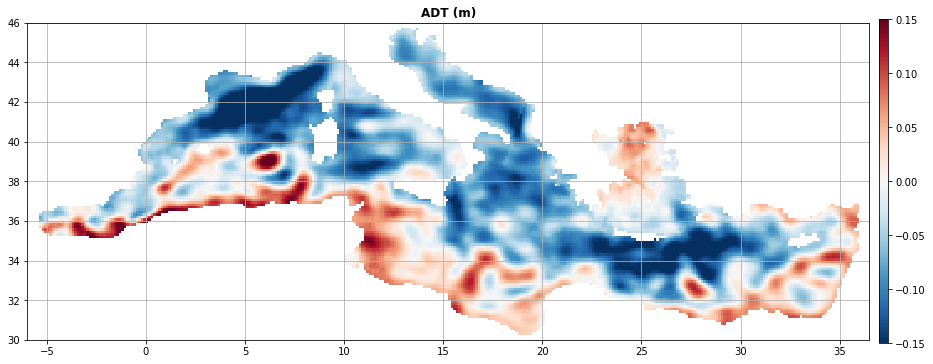

In [5]:
g = RegularGridDataset(
    data.get_demo_path("dt_med_allsat_phy_l4_20160515_20190101.nc"),
    "longitude",
    "latitude",
)

ax = start_axes("ADT (m)")
m = g.display(ax, "adt", vmin=-0.15, vmax=0.15, cmap="RdBu_r")
update_axes(ax, m)

In [8]:
g.variables

dict_keys(['latitude', 'longitude', 'adt', 'sla'])

## Get geostrophic speed u,v
U/V are deduced from ADT, this algortihm is not ok near the equator (~+- 2°)



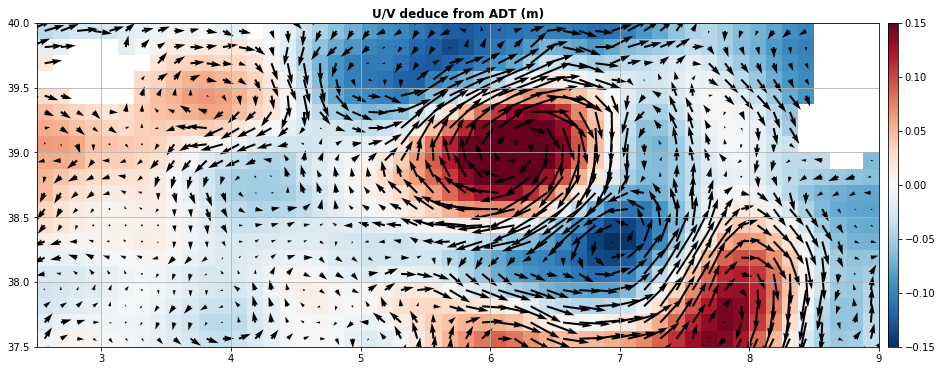

In [9]:
g.add_uv("adt")
ax = start_axes("U/V deduce from ADT (m)")
ax.set_xlim(2.5, 9), ax.set_ylim(37.5, 40)
m = g.display(ax, "adt", vmin=-0.15, vmax=0.15, cmap="RdBu_r")
u, v = g.grid("u").T, g.grid("v").T
ax.quiver(g.x_c, g.y_c, u, v, scale=10)
update_axes(ax, m)

## Pre-processings
Apply a high-pass filter to remove the large scale and highlight the mesoscale



In [ ]:
g.bessel_high_filter("adt", 500)
ax = start_axes("ADT (m) filtered (500km)")
m = g.display(ax, "adt", vmin=-0.15, vmax=0.15, cmap="RdBu_r")
update_axes(ax, m)

## Identification
Run the identification step with slices of 2 mm



In [ ]:
date = datetime(2016, 5, 15)
a, c = g.eddy_identification("adt", "u", "v", date, 0.002, shape_error=55)

Display of all closed contours found in the grid (only 1 contour every 4)



In [ ]:
ax = start_axes("ADT closed contours (only 1 / 4 levels)")
g.contours.display(ax, step=4)
update_axes(ax)

Contours included in eddies



In [ ]:
ax = start_axes("ADT contours used as eddies")
g.contours.display(ax, only_used=True)
update_axes(ax)

## Post analysis
Contours can be rejected for several reasons (shape error to high, several extremum in contour, ...)



In [ ]:
ax = start_axes("ADT rejected contours")
g.contours.display(ax, only_unused=True)
update_axes(ax)

Criteria for rejecting a contour:
 0. - Accepted (green)
 1. - Rejection for shape error (red)
 2. - Masked value within contour (blue)
 3. - Under or over the pixel limit bounds (black)
 4. - Amplitude criterion (yellow)



In [ ]:
ax = start_axes("Contours' rejection criteria")
g.contours.display(ax, only_unused=True, lw=0.5, display_criterion=True)
update_axes(ax)

Display the shape error of each tested contour, the limit of shape error is set to 55 %



In [ ]:
ax = start_axes("Contour shape error")
m = g.contours.display(
    ax, lw=0.5, field="shape_error", bins=arange(20, 90.1, 5), cmap="PRGn_r"
)
update_axes(ax, m)

Some closed contours contains several eddies (aka, more than one extremum)



In [ ]:
ax = start_axes("ADT rejected contours containing eddies")
g.contours.label_contour_unused_which_contain_eddies(a)
g.contours.label_contour_unused_which_contain_eddies(c)
g.contours.display(
    ax,
    only_contain_eddies=True,
    color="k",
    lw=1,
    label="Could be a contour of interaction",
)
a.display(ax, color="r", linewidth=0.75, label="Anticyclonic", ref=-10)
c.display(ax, color="b", linewidth=0.75, label="Cyclonic", ref=-10)
ax.legend()
update_axes(ax)

## Output
When displaying the detected eddies, dashed lines are for effective contour, solide lines for the contour of
the maximum mean speed. See figure 1 of https://doi.org/10.1175/JTECH-D-14-00019.1



In [ ]:
ax = start_axes("Detected Eddies")
a.display(
    ax, color="r", linewidth=0.75, label="Anticyclonic ({nb_obs} eddies)", ref=-10
)
c.display(ax, color="b", linewidth=0.75, label="Cyclonic ({nb_obs} eddies)", ref=-10)
ax.legend()
update_axes(ax)

Display the speed radius of the detected eddies



In [ ]:
ax = start_axes("Speed Radius (km)")
kwargs = dict(vmin=10, vmax=50, s=80, ref=-10, cmap="magma_r", factor=0.001)
a.scatter(ax, "radius_s", **kwargs)
m = c.scatter(ax, "radius_s", **kwargs)
update_axes(ax, m)

Filling the effective radius contours with the effective radius values



In [ ]:
ax = start_axes("Effective Radius (km)")
kwargs = dict(vmin=10, vmax=80, cmap="magma_r", factor=0.001, lut=14, ref=-10)
a.filled(ax, "effective_radius", **kwargs)
m = c.filled(ax, "radius_e", **kwargs)
update_axes(ax, m)